# Import statements

In [1]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import utils

# Parse and plot spot instance prices

In [3]:
from datetime import datetime
import os

import pylab
def plot_prices_legend(output_filename=None):
    
    fig = pylab.figure()
    figlegend = pylab.figure(figsize=(10, 1))
    
    ax = fig.add_subplot(111)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    markers = ['^', 'o', 'o', 's', 's']
    labels = ['GCP', 'AWS (max)', 'AWS (min)', 'Azure (max)', 'Azure (min)']
    lines = []
    for i, (color, marker) in enumerate(zip(colors, markers)):
        line = ax.plot(range(5),
                       range(5),
                       marker=marker,
                       color=color,
                       linewidth=3,
                       markersize=15)
        lines.append(line)
        
    figlegend.legend(
        [line[0] for line in lines],
        labels,
        loc='center',
        ncol=(len(labels) // 2) + 1,
        frameon=False,
        labelspacing=0.2,
        columnspacing=0.6, handlelength=1.4,)

    if output_filename is not None:
        figlegend.savefig(output_filename)

def plot_prices(aws_per_instance_type_spot_prices,
                gcp_per_instance_type_spot_prices,
                azure_per_instance_type_spot_prices,
                output_directory=None):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    all_timestamps = []
    for instance_type in azure_per_instance_type_spot_prices:
        all_timestamps.extend(
            [x[1]
             for x in azure_per_instance_type_spot_prices[instance_type]])
    all_timestamps.sort()
    first_timestamp = all_timestamps[0]
    
    instance_types = [
        ('nvidia-tesla-v100', 1), ('nvidia-tesla-v100', 2),
        ('nvidia-tesla-v100', 4), ('nvidia-tesla-v100', 8),
        ('nvidia-tesla-p100', 1), ('nvidia-tesla-p100', 2),
        ('nvidia-tesla-p100', 4),
        ('nvidia-tesla-k80', 1), ('nvidia-tesla-k80', 2),
        ('nvidia-tesla-k80', 4), ('nvidia-tesla-k80', 8),
    ]
    aws_instance_types = {
        ('nvidia-tesla-v100', 1): 'p3.2xlarge',
        ('nvidia-tesla-v100', 4): 'p3.8xlarge',
        ('nvidia-tesla-v100', 8): 'p3.16xlarge',
        ('nvidia-tesla-k80', 1): 'p2.xlarge',
        ('nvidia-tesla-k80', 8): 'p2.8xlarge',
        ('nvidia-tesla-k80', 16): 'p2.16xlarge',
    }
    azure_instance_mapping = utils.read_azure_instance_mapping_file(
        "../logs/azure/instance_mapping.csv")
    azure_inverse_instance_mapping = {}
    for k, v in azure_instance_mapping.items():
        if "r" in k: continue
        azure_inverse_instance_mapping[v] = k
    min_per_instance_type_spot_prices = {}
    
    for instance_type in instance_types:
        plt.figure(figsize=(6.5, 3))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
        
        # Plot GCP prices.
        for x in gcp_per_instance_type_spot_prices[instance_type]:
            spot_price = float(x[1].replace("$", ""))
            break
        ax.plot([(timestamp - first_timestamp).total_seconds() / (24 * 3600)
                 for timestamp in all_timestamps],
                [spot_price for timestamp in all_timestamps],
                label="GCP",
                marker='^', color=colors[0])
        
        # Plot AWS prices.
        min_per_instance_type_spot_prices[instance_type] = {}
        for per_instance_type_spot_prices in aws_per_instance_type_spot_prices:

            if instance_type not in aws_instance_types:
                continue
            aws_instance_type = aws_instance_types[instance_type]
            if aws_instance_type not in per_instance_type_spot_prices:
                continue
            
            for x in per_instance_type_spot_prices[aws_instance_type]:
                time_in_hours = (x['Timestamp'] - first_timestamp).total_seconds() / (3600 * 24)
                if time_in_hours not in min_per_instance_type_spot_prices[instance_type]:
                    min_per_instance_type_spot_prices[instance_type][time_in_hours] = []
                min_per_instance_type_spot_prices[instance_type][time_in_hours].append(
                    float(x['SpotPrice'])
                )
            timestamps = sorted(list(
                min_per_instance_type_spot_prices[instance_type].keys()))
            spot_prices = [max(min_per_instance_type_spot_prices[instance_type][timestamp])
                           for timestamp in timestamps]
            ax.plot(timestamps, spot_prices, label="AWS (max)",
                    marker='o', color=colors[1])
            spot_prices = [min(min_per_instance_type_spot_prices[instance_type][timestamp])
                           for timestamp in timestamps]
            ax.plot(timestamps, spot_prices, label="AWS (min)",
                    marker='o', color=colors[2])
        
        # Plot Azure prices.
        instance_type = (instance_type[0].replace("nvidia-tesla-", ""), instance_type[1])
        if instance_type in azure_inverse_instance_mapping:
            azure_instance_type = azure_inverse_instance_mapping[instance_type]
            min_per_instance_type_spot_prices[azure_instance_type] = {}
            for x in azure_per_instance_type_spot_prices[azure_instance_type]:

                time_in_hours = (x[1] - first_timestamp).total_seconds() / (3600 * 24)
                if time_in_hours not in min_per_instance_type_spot_prices[azure_instance_type]:
                    min_per_instance_type_spot_prices[azure_instance_type][time_in_hours] = []
                if x[2].strip() != "":
                    min_per_instance_type_spot_prices[azure_instance_type][time_in_hours].append(
                        float(x[2].replace("$", ""))
                    )
            timestamps = sorted(list(min_per_instance_type_spot_prices[azure_instance_type].keys()))
            spot_prices = [max(min_per_instance_type_spot_prices[azure_instance_type][timestamp])
                           for timestamp in timestamps]
            ax.plot(timestamps, spot_prices, label="Azure (max)",
                    marker='s', color=colors[3])
            spot_prices = [min(min_per_instance_type_spot_prices[azure_instance_type][timestamp])
                           for timestamp in timestamps]
            ax.plot(timestamps, spot_prices, label="Azure (min)",
                    marker='s', color=colors[4])

        ax.set_ylabel("Price ($/hr)")
        ax.set_xlabel("Time (days)")
        ax.set_ylim([0, None])
        ax.set_xlim([0, 25])
        sns.despine()

        print(instance_type)
        if output_directory is not None:
            output_filename = os.path.join(output_directory,
                                           '%dx%s.pdf' % (instance_type[1], instance_type[0]))
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')
                
        leg = plt.figlegend(
            loc='center',
            ncol=3,
            frameon=False,
            labelspacing=0.2,
            columnspacing=0.6, handlelength=1.4,)
        bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
        y_offset = 0.7
        bb.y0 += y_offset
        bb.y1 += y_offset
        leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

        plt.show()

('v100', 1)


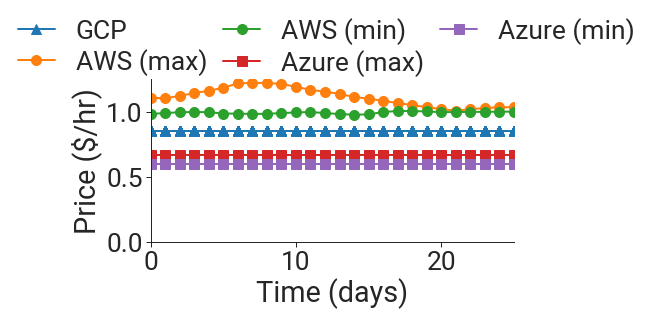

('v100', 2)


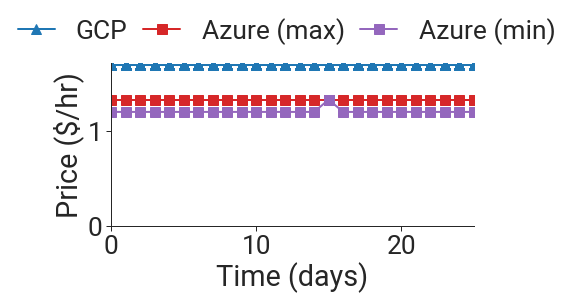

('v100', 4)


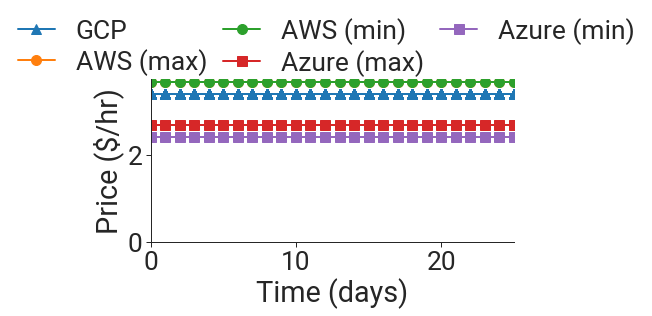

('v100', 8)


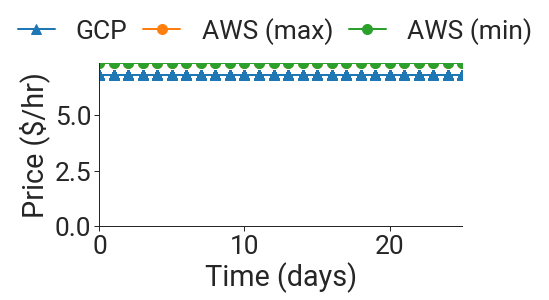

('p100', 1)


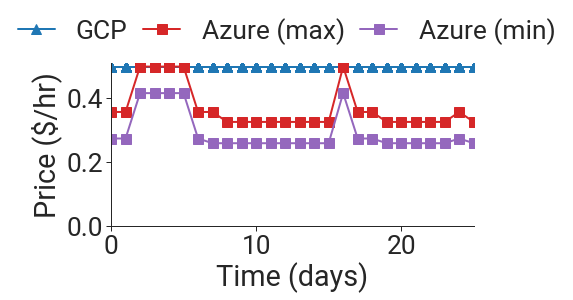

('p100', 2)


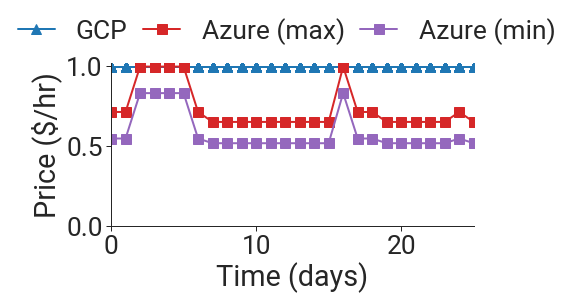

('p100', 4)


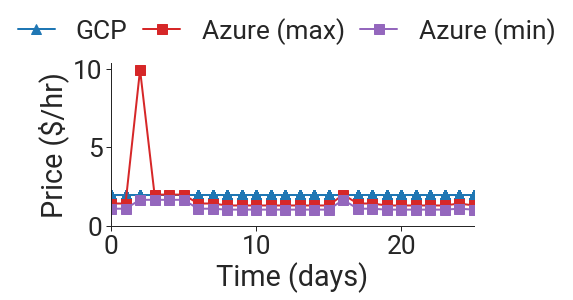

('k80', 1)


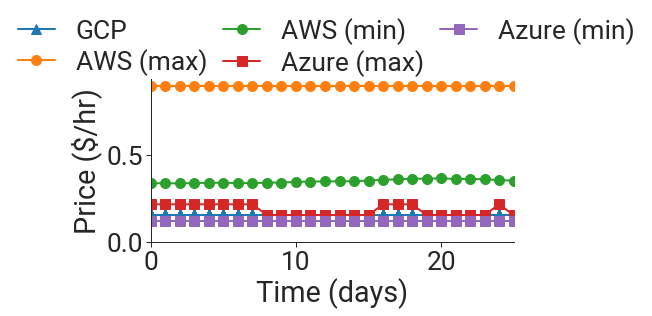

('k80', 2)


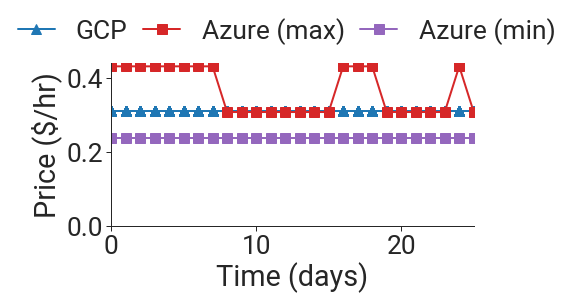

('k80', 4)


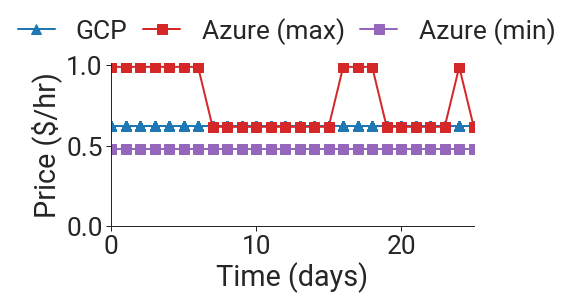

('k80', 8)


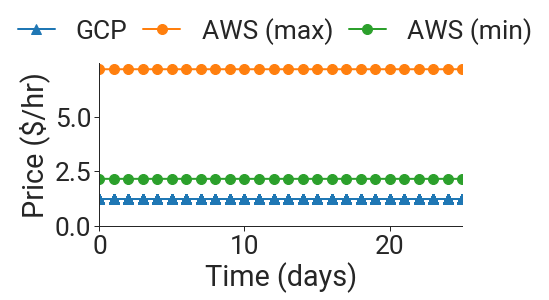

In [4]:
plot_legend = False
if plot_legend:
    plot_prices_legend(output_filename="../overlaid/graphs/legend.pdf")
plot_prices([utils.read_aws_prices("../logs/aws/cost/us-east-1", summary=False)],
            utils.read_gcp_prices("../logs/gcp/spin_up_and_shut_down"),
            utils.read_azure_prices("../logs/azure/cost"),
            output_directory="../graphs/overlaid/cost/")